Materi ini dibuat dari repositori asli pada tautan berikut: (https://github.com/dizhu-gis/SRGCNN). Original paper dapat diakses pada [tautan berikut](https://link.springer.com/article/10.1007/s10707-021-00454-x)

Model SRGCNN dibangun menggunakan `pytorch`, penggunaan `GPU` akan membantu proses training model lebih cepat. Untuk membangun keteanggan spasial (Spatial Autocorrelation) digunakan `Python Spatial Analysis Library (PySAL)`. Lebih detil PySAL dapat dilihat [disini](https://pysal.org/spreg/api.html).

- Environment di test menggunakan:  `python 3.9.6`, `pytorch 1.10.0`, `cudatoolkit 11.1`

### 1. Import package yang diperlukan

In [2]:
### untuk mengabaikan perintah warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sns
### pytorch
import torch
from torch import nn
import torch.nn.functional as F
### pysal
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights
### esda
import esda
### sklearn
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import median_absolute_error as mae

In [4]:
# enable cuda gpu accelaration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.set_printoptions(suppress=True)

In [5]:
device

device(type='cuda', index=0)

### 2. Functionalities

In [6]:
def make_sym_matrix_boolean_sum(mx): # This will ensure the adjacent matrix to be symmetric no matter ways of definition
    return 1 * np.logical_or(mx, mx.T)

def renormalized_trick_mx(mx): # This will add diagonal ones for the adjacent matrix
    return mx + np.eye(mx.shape[0])

def renormalized_trick_laplacian(mx_tilde):    
    degree_tilde = np.diag(np.sum(mx_tilde, axis=1))
    D_tilde_inv_sqrt = np.linalg.inv(np.sqrt(degree_tilde))
    return np.dot(D_tilde_inv_sqrt,mx_tilde).dot(D_tilde_inv_sqrt)
    
def step(model,optimizer,input_tensor,idx,target_tensor,adj): ##idx: use ids in the training set
    ''' train with element-wise loss vector，return the mean scalar of the loss '''
    with torch.autograd.set_detect_anomaly(True):
        model.train()
        optimizer.zero_grad()
        output = model(input_tensor, adj)
        loss = F.mse_loss(output[idx], target_tensor[idx], reduce=False)
        loss.backward(torch.reshape(torch.ones(len(idx)).to(device), (len(idx),1)), retain_graph=False)
        optimizer.step()
        return loss.mean().item()

def evaluate(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the validation set
    ''' Monitor the loss of validation set during the training '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx], reduce=False)
    return loss.mean().item()

def evaluate_MAE(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the training set
    ''' Monitor the Mean abosolute error of validation set during the training '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.l1_loss(output[idx], target_tensor[idx], reduce=False)
    return loss.mean().item()

def evaluate_MAPE(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the validation set
    ''' Monitor the Mean abosolute percentage error of validation set during the training '''
    model.eval()
    output = model(input_tensor, adj)
    MAPE = F.l1_loss(output[idx], target_tensor[idx], reduce=False) / target_tensor[idx]
    return MAPE.mean().item() 

def return_results(model,input_tensor,idx,target_tensor,adj): ## return results as arrays
    ''' call a model and get the predicted array and the ground truth array '''
    model.eval()
    output = model(input_tensor, adj)
    return output[idx].cpu().detach().numpy(), target_tensor[idx].cpu().detach().numpy()

### 3. Models

Terdapat dua model dalam materi ini yakni `SRGCNN` dan `SRGCNN-GW`

In [7]:
class GraphConvolution(nn.Module):
    """Basic graph convolution operation that incorporate both spatial lagged X 
    and spatial lagged Y (to be used in the basic SRGCNNs model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=nn.ReLU()):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out), requires_grad=True) #
        self.bias = nn.Parameter(torch.FloatTensor(f_out), requires_grad=True) if use_bias else None
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)
        
    def forward(self, input, adj):
##      ---- self.method=='SRGCNN':
        support = torch.mm(input, self.weight)
        out = torch.mm(adj, support) #adj here has to be renormalized
        
        if self.use_bias: out.add_(self.bias) #
        if self.activation is not None: 
            out=self.activation(out) 
        return out

class GCN(nn.Module):
    """Basic SRGCNN model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GraphConvolution(f_in, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GraphConvolution(f_out, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
    
        
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: x = F.dropout(x, d, training=self.training, inplace=False)
             
        return self.out_layer(x, adj)
        
class GWGraphConvolution(nn.Module):
    """Geographically weighted graph convolution operation that 
    adds locally parameterized weights to all the variables (to be used in the SRGCNNs-GW model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=nn.ReLU()):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        #########Geographically local parameters
        self.gwr_weight = nn.Parameter(torch.FloatTensor(x_tensor.shape[0], f_in),requires_grad=True)
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True) #
        self.bias = nn.Parameter(torch.FloatTensor(f_out),requires_grad=True) if use_bias else None
        self.initialize_weights()
    
    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        nn.init.constant_(self.gwr_weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)
        
    def forward(self, input, adj):
##      ---- self.method=='SRGCNN-GW':
        gwr_support=torch.mul(input,self.gwr_weight) # use torch.mul to enable element-wise product
        support=torch.mm(adj,gwr_support) #adj here has to be renormalized     
        out=torch.mm(support,self.weight)
        
        if self.use_bias: out.add_(self.bias) #
        if self.activation is not None: 
            out=self.activation(out) 
        return out

class GWGCN(nn.Module):
    """SRGCNN-GW model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GWGraphConvolution(f_in, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GWGraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GWGraphConvolution(f_out, n_classes, activation=None)# for spatial regression tasks: no activation func after the output layer
    
    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: x = F.dropout(x, d, training=self.training, inplace=False)
            
        return self.out_layer(x, adj)

### 4. Case Data 
Contoh data yang digunakan adalah data dari original paper, yakni data properti di San Diego US seperti jumlah kamar, kamar mandi, kolam renang dll.

Dalam kasus ini akan coba diduga nilai harga properti berdasarkan fasilitas yang ada dari properti tersebut dengan mempertimbangkan kondisi properti lain disekitarnya.

In [8]:
db = gp.read_file('./airbnb/regression_db.geojson')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

In [9]:
# melihat contoh data
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [10]:
# Model ini menggunakan multivariate atau multi variable. Mendefinisikan variabel x (input) yang akan digunakan sebagai variabel penduga, 
# dalam latihan ini digunakan 4 variabel
variable_names = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds'
]
# jika ingin menggunakan variabel lainnya, dapat didefinisikan seperti berikut
variable_names_append = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds', 
    'rt_Private_room', 
    'rt_Shared_room',
    'pg_Condominium', 
    'pg_House', 
    'pg_Other', 
    'pg_Townhouse',
    'coastal'
]

<Axes: xlabel='price', ylabel='Density'>

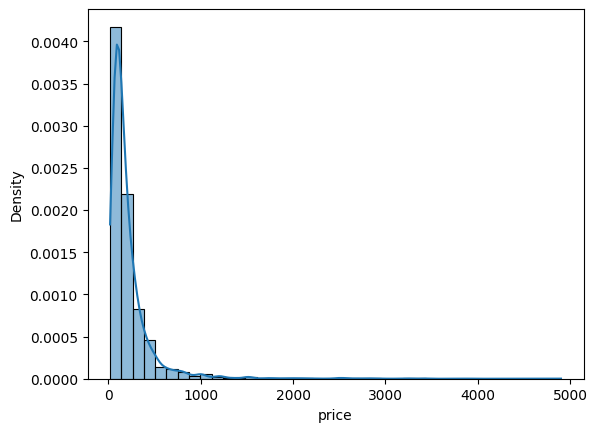

In [11]:
# Variabel y (output) yang ingin diduga adalah variabel harga.
# Seperti terlihat, variabel harga tidak menyebar normal.
sns.histplot(db.price, bins=40, kde=True, stat="density")

<Axes: xlabel='log_price', ylabel='Density'>

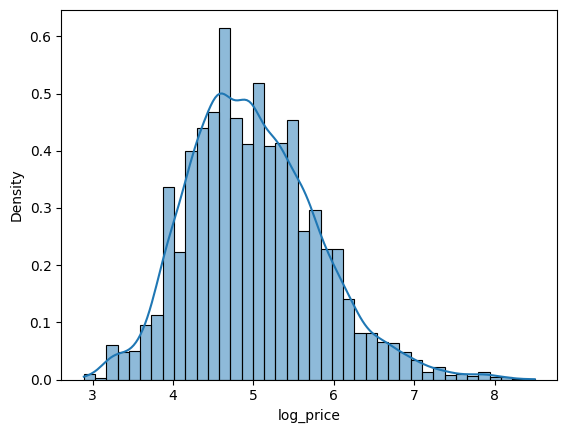

In [12]:
# Untuk memudahkan dan mempercepat proses learning variabel-variabel yang tidak menyebar normal, biasanya dilakukan normalisasi atau standarisasi
# Variabel harga setelah di normalisasi menggunakan logaritma
sns.histplot(db.log_price, bins=40, kde=True, stat="density")

<Axes: >

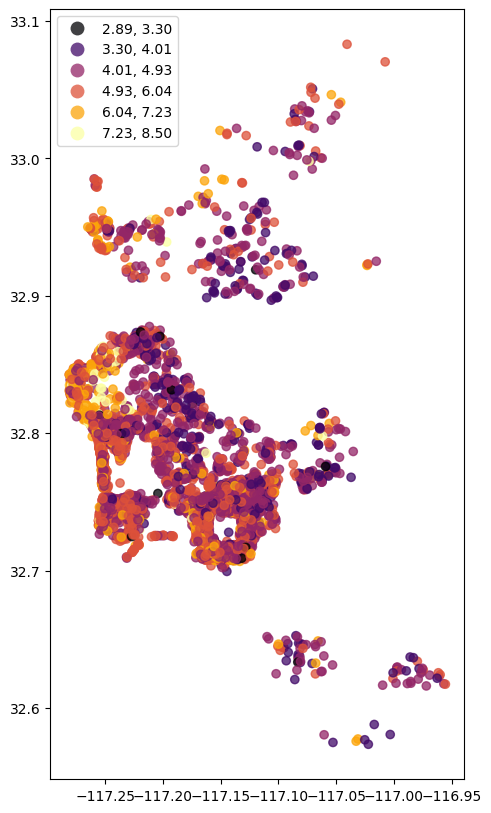

In [13]:
# Berikut adalah sebaran spasial properti berdasarkan log_price
f, ax = plt.subplots(1, 1, figsize=(10,10))
db.plot(column='log_price', cmap='inferno', scheme='percentiles', alpha=0.75, legend=True, ax=ax)

### 4. Settings

Menggunakan PySAL dibuat nilai ketetanggaan spasial antar properti. Dalam latihan ini, untuk nilai ketetanggan menggunakan Algoritma K-Nearest Neighbors (KNN) dengan 20 ketetanggaan.

Terdapat banyak algoritma ketetanggaan spasial yang dapat digunakan seperti Queen, Rook, KNN dll dapat dilihat pada tautan berikut (https://pysal.org/libpysal/api.html).

In [46]:
knn = weights.KNN.from_dataframe(db, geom_col='geometry', k=20)

In [47]:
np.info(knn.full()[0])

class:  ndarray
shape:  (6110, 6110)
strides:  (48880, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x28aad672040
byteorder:  little
byteswap:  False
type: float64


<img src="img/SpatialAutocorrelation.png" height="200"/>

In [48]:
np.set_printoptions(threshold=np.inf)
knn.full()[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

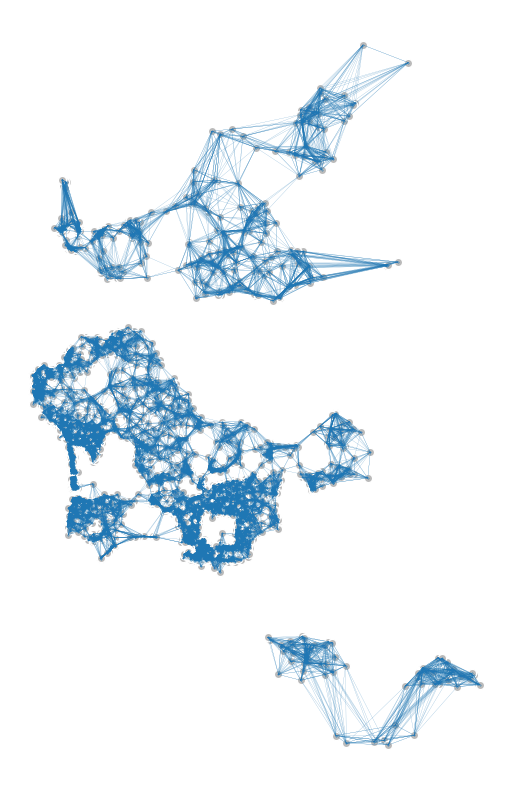

In [49]:
plot_spatial_weights(knn, db,
                     edge_kws=dict(linewidth=0.1),
                     nonplanar_edge_kws=dict(color='#4393c3'),
                     node_kws=dict(markersize=0.1))

Membuat adjacent matrix

<img src="img/AdjacentMatrix.png" height="200"/>

In [50]:
# adjacent matrix
A_20nn_sym = make_sym_matrix_boolean_sum(knn.full()[0])

Mengisi diagonal matrik dengan nilai 1

<img src="img/DIagonal.png" height="200"/>

In [53]:
# Mengisi diagonal matrik dengan nilai 1
A_tilde_20nn_sym = renormalized_trick_mx(A_20nn_sym)

In [ ]:
Laplacian_knn = renormalized_trick_laplacian(A_tilde_20nn_sym)

adj = torch.FloatTensor(Laplacian_knn).to(device)

In [23]:
### The observations for data regression
x_tensor = torch.FloatTensor(db[variable_names].values.tolist()).to(device)
#x_append_tensor = torch.FloatTensor(db[variable_names_append].values.tolist()).to(device)
y_tensor = torch.FloatTensor(db[['log_price']].values.tolist()).to(device)
idx_all = torch.LongTensor(db.index.values).to(device)

In [24]:
### Params settings for the model on limited Xs
n_labels = 1 # #output feature dimension:log_price
n_features = len(variable_names)# #input feature dimensional vector
epochs = 18000 # #max training epoch
lr = 3e-2 ##learning rate

### 5. Train the Model
For demo usage, we here only show a simple case for SRGCNN-GW without further fine tuning; try `model=GCN(...)` for the basic SRGCNN model; try replace `x_tensor` with `x_append_tensor` and `n_features` for another scenario of independent variables; try change the array of hidden layers and corresponding dropouts in `GWGCN()` to test different model architectures; try more training epochs and smaller learning rate to obtain better fitting accuracy.

In [25]:
model = GWGCN(n_features, n_labels, hidden=[8*n_features], dropouts=[0.5]).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr, weight_decay=lr)
lowest_mean_global_MAPE = 99999.0
min_global_MAPE_epoch = -1
train_loss_arr = []
mape_arr = []
for i in range(0, epochs):
    train_loss = step(model, optimizer, x_tensor, idx_all, y_tensor, adj) ## For demo, train with all ids "idx_all"
    train_loss_arr.append(train_loss)
    global_MAPE = evaluate_MAPE(model, x_tensor, idx_all, y_tensor, adj) ## For demo, evaluate with again all ids "idx_all"
    mape_arr.append(global_MAPE * 100)

    if global_MAPE < lowest_mean_global_MAPE:
        lowest_mean_global_MAPE = global_MAPE
        output, target = return_results(model, x_tensor, idx_all, y_tensor, adj)
        min_global_MAPE_epoch = i
        
    if i%1000==0 or i==epochs-1:
        print("epoch:"+str(i)+"--train_loss:"+str(train_loss))
        print(" --global_MAPE:"+'{:.4f}%'.format(global_MAPE*100))

epoch:0--train_loss:95432.8984375
 --global_MAPE:5269.7556%
epoch:1000--train_loss:0.5921961069107056
 --global_MAPE:11.7433%
epoch:2000--train_loss:0.5326780080795288
 --global_MAPE:11.0405%
epoch:3000--train_loss:0.5062400698661804
 --global_MAPE:10.7061%
epoch:4000--train_loss:0.47707992792129517
 --global_MAPE:10.3631%
epoch:5000--train_loss:0.44278356432914734
 --global_MAPE:10.0101%
epoch:6000--train_loss:0.4129464030265808
 --global_MAPE:9.6027%
epoch:7000--train_loss:0.3690384030342102
 --global_MAPE:9.1350%
epoch:8000--train_loss:0.3380109369754791
 --global_MAPE:8.5930%
epoch:9000--train_loss:0.29067716002464294
 --global_MAPE:7.9520%
epoch:10000--train_loss:0.2567715346813202
 --global_MAPE:7.2396%
epoch:11000--train_loss:0.24154825508594513
 --global_MAPE:6.7878%
epoch:12000--train_loss:0.2230166494846344
 --global_MAPE:6.6472%
epoch:13000--train_loss:0.23124144971370697
 --global_MAPE:6.7169%
epoch:14000--train_loss:0.23087826371192932
 --global_MAPE:6.8545%
epoch:15000--t

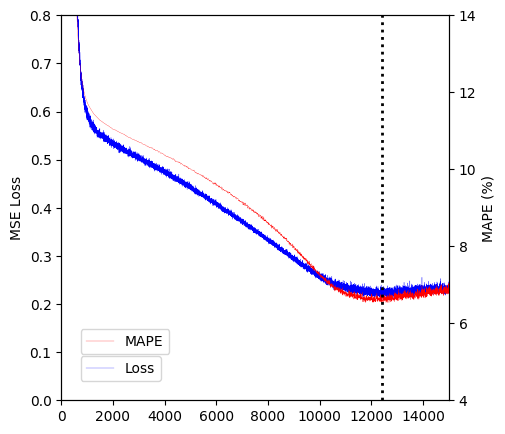

In [26]:
f,ax=plt.subplots(1, 1, figsize=(5,5))
ax.plot(train_loss_arr, lw=0.2, color='b', alpha=1, label='Loss')
ax.set_xlim([0, 15000])
ax.set_ylim([0, 0.8])
ax2=ax.twinx()
ax2.plot(mape_arr, lw=0.2, color='r', alpha=1, label='MAPE')
ax2.set_ylim([4, 14])
ax2.legend(loc=(0.05, 0.12))
ax.legend(loc=(0.05, 0.05))
ax.set_ylabel('MSE Loss')
ax2.set_ylabel('MAPE (%)')
plt.axvline(min_global_MAPE_epoch, linestyle="dotted", linewidth=2, color='black')

### 6. Output Statistics

The best results are recorded in the output array

In [27]:
mape = (mae(output, target) / target).mean()
mape # mean absolute percentage error between predicted y and the real y

0.052092426

Model goodness of fit

In [28]:
SSE = np.sum((target - output)**2)
SST = np.sum((db[['log_price']].values - db[['log_price']].values.mean())**2)

Rsq = 1 - SSE/SST
Rsq # R-square of model fit

0.7239663644818066

Moran's I of the model errors

In [29]:
Ierror = esda.moran.Moran(output - target, knn)
print('Errors  moransI: ' + str(Ierror.I) + '  Z_I: ' + str(Ierror.z_norm) + ' p-value: ' + str(Ierror.p_sim))

Errors  moransI: 0.011118479910635989  Z_I: 2.9433217753743453 p-value: 0.003


### 7. Visualization

Text(0.5, 1.0, 'error')

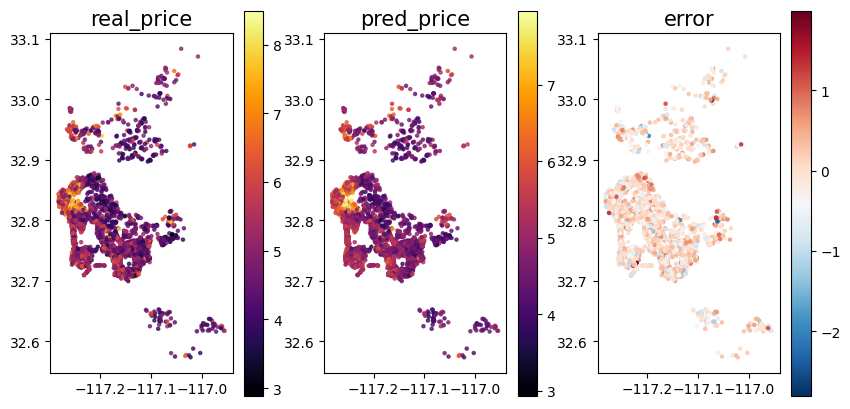

In [30]:
dbplot = db.loc[:, ['log_price','geometry']].copy()
dbplot['pred'] = output
dbplot['error'] = output - db[['log_price']].values

f, ax = plt.subplots(1, 3, figsize=(10,5))

dbplot.plot(column='log_price', cmap='inferno', s=5, alpha=0.75, legend=True, ax=ax[0])
dbplot.plot(column='pred', cmap='inferno', s=5, alpha=0.75, legend=True, ax=ax[1])
dbplot.plot(column='error', cmap='RdBu_r', s=5, alpha=1, legend=True, ax=ax[2])
ax[0].set_title('real_price', fontsize=15)
ax[1].set_title('pred_price', fontsize=15)
ax[2].set_title('error', fontsize=15)

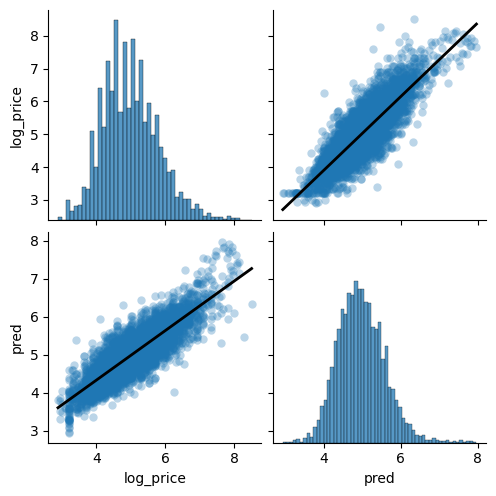

In [32]:
sns.pairplot(dbplot.drop('error', axis=1), diag_kind="hist",\
             kind='reg', plot_kws={'line_kws':{'color':'black', 'lw':2}, 'scatter_kws': {'linewidths':0, 'alpha': 0.3}})